# IMPORT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers sentencepiece torch

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from torch.utils.data import Dataset
import numpy as np
from torch.optim import AdamW
from transformers import BertModel
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# DATA

In [ ]:
df = pd.read_csv('emotion_tokenized_data.csv')
df

,Emotion,Path,Length,Text,cleaned_text,tokenized
0,angry,/content/drive/MyDrive/project/data_aihub/4/5e...,4.565333,10년도 넘었어 고등학교 동창,10년도 넘었어 고등학교 동창,"{'input_ids': tensor([[ 2, 0, 0, 5441,..."
1,angry,/content/drive/MyDrive/project/data_aihub/4/5e...,8.576000,10분마다 연락을 해 봤지 근데 아직도이 녀석 온다고 말하지 오지 않고 있어,10분마다 연락을 해 봤지 근데 아직도이 녀석 온다고 말하지 오지 않고 있어,"{'input_ids': tensor([[ 2, 0, 0, 7848,..."
2,angry,/content/drive/MyDrive/project/data_aihub/4/5e...,7.040000,1년 채우고 그만두려고 했는데 아 지금 같아서는 진짜 회사 옮기고 싶다,1년 채우고 그만두려고 했는데 아 지금 같아서는 진짜 회사 옮기고 싶다,"{'input_ids': tensor([[ 2, 0, 0, 0,..."
3,angry,/content/drive/MyDrive/project/data_aihub/4/5e...,5.034667,1시간 기다렸나 봐 다리도 아프고 짜증 나,1시간 기다렸나 봐 다리도 아프고 짜증 나,"{'input_ids': tensor([[ 2, 0, 0, 6393,..."
4,angry,/content/drive/MyDrive/project/data_aihub/4/5e...,4.266667,1시간 기다렸는데 아직도 안 와,1시간 기다렸는데 아직도 안 와,"{'input_ids': tensor([[ 2, 0, 0, 0,..."
...,...,...,...,...,...,...
14377,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...,10.880000,힘들다 그만둬야 할까 어떻게 해야 될까 정말 고민이 많이 되는 거 같아 어떡하면 좋겠니,힘들다 그만둬야 할까 어떻게 해야 될까 정말 고민이 많이 되는 거 같아 어떡하면 좋겠니,"{'input_ids': tensor([[ 2, 0, 0, 0,..."
14378,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...,4.821333,힘들다 힘들어,힘들다 힘들어,"{'input_ids': tensor([[2, 0, 0, 3, 1, 1, 1, 1,..."
14379,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...,5.248000,힘들어 다른 회사 또 준비를 할 거야 나는,힘들어 다른 회사 또 준비를 할 거야 나는,"{'input_ids': tensor([[ 2, 0, 5783, 7957,..."
14380,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...,3.114667,힘들어하고 나도 너무 힘들어,힘들어하고 나도 너무 힘들어,"{'input_ids': tensor([[2, 0, 0, 0, 0, 3, 1, 1,..."


In [ ]:
label_mapping = {'happiness': 0, 'sadness': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'disgust': 5}

In [ ]:
df['Emotion'] = df['Emotion'].map(label_mapping)

In [ ]:
df['Emotion'].unique()

array([2, 5, 4, 0, 3, 1])

In [ ]:
df[['Emotion', 'cleaned_text']]

,Emotion,cleaned_text
0,2,10년도 넘었어 고등학교 동창
1,2,10분마다 연락을 해 봤지 근데 아직도이 녀석 온다고 말하지 오지 않고 있어
2,2,1년 채우고 그만두려고 했는데 아 지금 같아서는 진짜 회사 옮기고 싶다
3,2,1시간 기다렸나 봐 다리도 아프고 짜증 나
4,2,1시간 기다렸는데 아직도 안 와
...,...,...
14377,1,힘들다 그만둬야 할까 어떻게 해야 될까 정말 고민이 많이 되는 거 같아 어떡하면 좋겠니
14378,1,힘들다 힘들어
14379,1,힘들어 다른 회사 또 준비를 할 거야 나는
14380,1,힘들어하고 나도 너무 힘들어


In [ ]:
emotion_counts = df['Emotion'].value_counts()

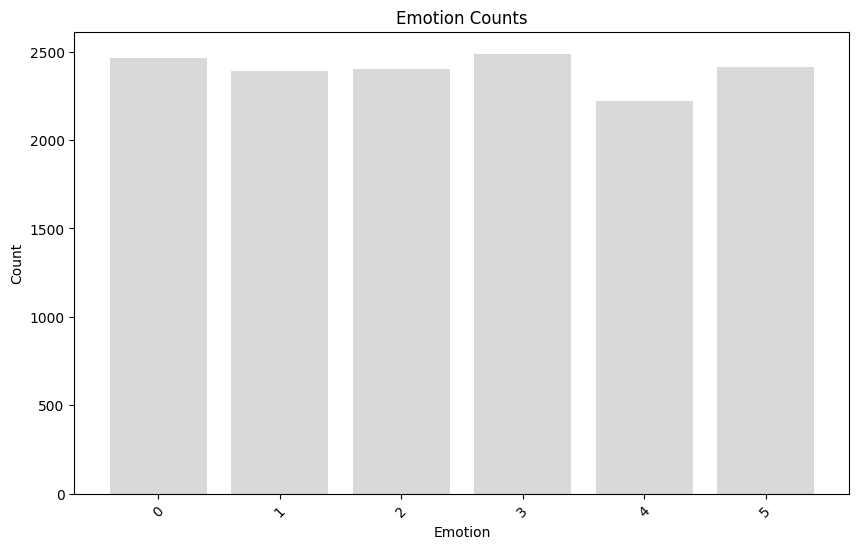

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values, color=['#D9D9D9'])  # 색상 직접 지정
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# KoBERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["cleaned_text"]
        emotion = self.data.iloc[index]["Emotion"]

        # KoBERT 토큰화
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(emotion, dtype=torch.long)  # 감정 레이블
        }

In [ ]:
class KoBERTEmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(KoBERTEmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('monologg/kobert')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 64
EPOCHS = 60
N_CLASSES = len(set(df['Emotion']))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_dataset = EmotionDataset(df, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = KoBERTEmotionClassifier(n_classes=N_CLASSES).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    accuracy, val_loss = eval_model(model, train_loader, device)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Validation Accuracy: {accuracy}, Validation Loss: {val_loss}')

Epoch 1/60, Train Loss: 1.7779000136955694, Validation Accuracy: 0.29224030037546933, Validation Loss: 1.7129418775687892
Epoch 2/60, Train Loss: 1.6148643595755963, Validation Accuracy: 0.4196217494089834, Validation Loss: 1.4526036878316368
Epoch 3/60, Train Loss: 1.4521524291547705, Validation Accuracy: 0.49408983451536637, Validation Loss: 1.31450470443297
Epoch 4/60, Train Loss: 1.361948160560298, Validation Accuracy: 0.5250312891113892, Validation Loss: 1.2306252513764564
Epoch 5/60, Train Loss: 1.2887644963349332, Validation Accuracy: 0.5561118064246975, Validation Loss: 1.153009749758363
Epoch 6/60, Train Loss: 1.2199441680521006, Validation Accuracy: 0.5806563760255875, Validation Loss: 1.0888384686030854
Epoch 7/60, Train Loss: 1.157713391326028, Validation Accuracy: 0.6063829787234042, Validation Loss: 1.0271345071652045
Epoch 8/60, Train Loss: 1.097670352399283, Validation Accuracy: 0.6238353497427339, Validation Loss: 0.9590231328705394
Epoch 9/60, Train Loss: 1.0517299002

In [ ]:
final_accuracy, final_loss = eval_model(model, train_loader, device)
print(f"Final Accuracy: {final_accuracy}, Final Loss: {final_loss}")

Final Accuracy: 0.7416214712835488, Final Loss: 0.5891581357231942


In [ ]:
model_save_path = "/content/drive/MyDrive/saved_kobert_emotion_model.pth"
tokenizer_save_path = "/content/drive/MyDrive/saved_tokenizer"

In [ ]:
torch.save(model.state_dict(), model_save_path)

In [ ]:
tokenizer.save_pretrained(tokenizer_save_path)
print(f"모델이 {model_save_path}에 저장되었습니다.")
print(f"토크나이저가 {tokenizer_save_path}에 저장되었습니다.")

모델이 /content/drive/MyDrive/saved_kobert_emotion_model.pth에 저장되었습니다.
토크나이저가 /content/drive/MyDrive/saved_tokenizer에 저장되었습니다.


# SVM, Logistic Regression, Random Forest

In [ ]:
X = df['cleaned_text']
y = df['Emotion']

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.721584984358707


In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.6854362182829337


In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

Logistic Regression Accuracy: 0.7167188043100452
